In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

import scipy.stats as stats
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
import pickle

In [2]:
raw_data = pd.read_csv('./2020 PPP Dataset/PPP Train ALL.csv')
raw_data.head()

,Unnamed: 0,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Index
0,0,Independent Contractors,CA - 49,LA JOLLA,04/30/2020,Unanswered,1.0,"U.S. Bank, National Association",$16300-27300,531210.0,N,Unanswered,CA,Unanswered,92037.0,Offices of Real Estate Agents and Brokers,1026947
1,1,Limited Liability Company(LLC),CA - 39,BREA,04/30/2020,Male Owned,4.0,"Bank of America, National Association",$7964-16300,423490.0,N,Unanswered,CA,Non-Veteran,92821.0,Other Professional Equipment and Supplies Merc...,1143280
2,2,Limited Liability Company(LLC),MI - 08,ROCHESTER HILLS,04/06/2020,Unanswered,208.0,Oxford Bank,$2-5 million,541612.0,N,Unanswered,MI,Unanswered,48309.0,Human Resources Consulting Services,286838
3,3,Independent Contractors,PA - 01,PHILADELPHIA,06/24/2020,Male Owned,1.0,Sun FCU,$0-7964,541430.0,N,White,PA,Unanswered,19123.0,Graphic Design Services,3727822
4,4,Sole Proprietorship,TX - 30,DALLAS,04/15/2020,Unanswered,10.0,"Texas Capital Bank, National Association",$56313-150000,522291.0,N,Unanswered,TX,Unanswered,75223.0,Consumer Lending,3960482


In [3]:
raw_data.shape

(3966377, 17)

In [4]:
raw_data = raw_data.drop(columns=['Unnamed: 0', 'Index'], axis=1)

In [5]:
raw_data[raw_data['NAICSCode'].isna()]

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,LoanRange,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry


In [6]:
data = raw_data.copy()
data['BusinessType'] = raw_data['BusinessType'].fillna('Other_BT')
data['City'] = raw_data['City'].fillna('Other_City')
data['Zip'] = raw_data['Zip'].fillna('Other').astype(str)
data['NAICSCode'] = raw_data['NAICSCode'].astype(str)

In [7]:
# Split loan range column
def split_loan_range(df):
    df['Loan_min'] = df['LoanRange'].map({
        '$16300-27300': 16300, '$7964-16300': 7964, '$0-7964': 0, '$56313-150000':56313,
           '$27300-56313': 27300, '$150,000-350,000': 150000, '$350,000-1 million':350000,
           '$1-2 million': 1000000, '$2-5 million': 2000000, '$5-10 million': 5000000
    })

    df['Loan_max'] = df['LoanRange'].map({
        '$16300-27300': 27300, '$7964-16300': 16300, '$0-7964': 7964, '$56313-150000':150000,
           '$27300-56313': 56313, '$150,000-350,000': 350000, '$350,000-1 million':1000000,
           '$1-2 million': 2000000, '$2-5 million': 5000000, '$5-10 million': 10000000
    })
    df = df.drop(columns=['LoanRange'], axis=1)
    return df

In [8]:
data = split_loan_range(data)

In [9]:
data.describe(include='all')

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Loan_min,Loan_max
count,3966377,3966377,3966377,3966377,3966377,3.966377e+06,3966377,3966377,3966377,3966377,3966377,3966377,3966377,3966377,3.966377e+06,3.966377e+06
unique,18,525,33773,79,3,NaN,4858,1057,2,9,51,3,35635,1057,NaN,NaN
top,Corporation,TX - 02,NEW YORK,04/28/2020,Unanswered,NaN,"Bank of America, National Association",722511.0,N,Unanswered,CA,Unanswered,10001.0,Full-Service Restaurants,NaN,NaN
freq,1149395,27714,47649,373702,3038019,NaN,269464,146877,3813123,3507995,454229,3337009,3973,146877,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.139693e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.293243e+04,1.753559e+05
std,NaN,NaN,NaN,NaN,NaN,3.262006e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.477068e+05,5.570224e+05
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,7.964000e+03
25%,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.964000e+03,1.630000e+04
50%,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.630000e+04,2.730000e+04
75%,NaN,NaN,NaN,NaN,NaN,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.631300e+04,1.500000e+05


In [10]:
set(data['Loan_max'] - data['Loan_min'])

{7964, 8336, 11000, 29013, 93687, 200000, 650000, 1000000, 3000000, 5000000}

In [11]:
upper_quantile = raw_data['JobsRetained'].quantile(0.95)
lower_quantile = raw_data['JobsRetained'].quantile(0.05)
lower_quantile, upper_quantile

(0.0, 44.0)

In [12]:
data = data[data['JobsRetained'] < upper_quantile]
data = data[data['JobsRetained'] > lower_quantile]
data['JobsRetained'] = data['JobsRetained'].astype(int)

In [13]:
data.describe(include='all')

,BusinessType,CD,City,DateApproved,Gender,JobsRetained,Lender,NAICSCode,NonProfit,RaceEthnicity,State,Veteran,Zip,Industry,Loan_min,Loan_max
count,3281982,3281982,3281982,3281982,3281982,3.281982e+06,3281982,3281982,3281982,3281982,3281982,3281982,3281982,3281982,3.281982e+06,3.281982e+06
unique,18,513,30604,79,3,NaN,4810,1057,2,9,51,3,35027,1057,NaN,NaN
top,Limited Liability Company(LLC),CA - 33,NEW YORK,04/28/2020,Unanswered,NaN,"Bank of America, National Association",722511.0,N,Unanswered,CA,Unanswered,10001.0,Full-Service Restaurants,NaN,NaN
freq,961544,22513,38257,319359,2470832,NaN,257229,114588,3164121,2872072,374060,2737437,3105,114588,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.939753e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.039352e+04,9.932918e+04
std,NaN,NaN,NaN,NaN,NaN,8.198909e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.226396e+04,1.852441e+05
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,7.964000e+03
25%,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.964000e+03,1.630000e+04
50%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.630000e+04,2.730000e+04
75%,NaN,NaN,NaN,NaN,NaN,9.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.631300e+04,1.500000e+05


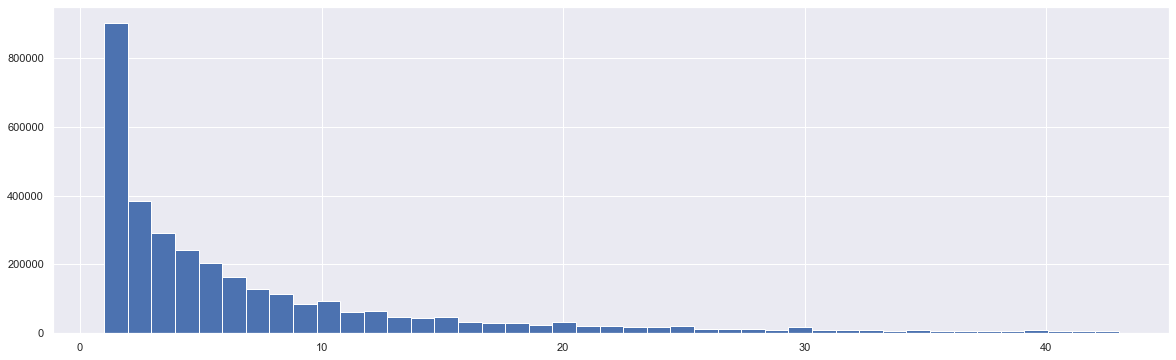

In [14]:
plt.figure(figsize=(20, 6))
plt.hist(data['JobsRetained'].astype(int), bins=len(data['JobsRetained'].unique()))
plt.show()

In [15]:
data['Loan_min'] = data['Loan_min'].astype(float)
data['Loan_max'] = data['Loan_max'].astype(float)

In [16]:
data['Industry'].value_counts().describe()

count      1057.000000
mean       3104.997162
std        8689.543353
min           3.000000
25%         175.000000
50%         631.000000
75%        2177.000000
max      114588.000000
Name: Industry, dtype: float64

In [17]:
annova_data_scaled=data.copy()
annova_data_scaled['JobsRetained'] = preprocessing.scale(annova_data_scaled['JobsRetained'])
annova_data_scaled['Loan_min'] = preprocessing.scale(annova_data_scaled['Loan_min'])
annova_data_scaled['Loan_max'] = preprocessing.scale(annova_data_scaled['Loan_max'])

In [20]:
len(annova_data_scaled['City'].iloc[:100].unique())

95

In [21]:
# Anova
lm = ols('JobsRetained ~ C(City) * C(Zip)', data=annova_data_scaled[['JobsRetained','City', 'Zip' ]].iloc[:100]).fit()
sm.stats.anova_lm(lm, typ=3)

C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9212, but rank is 96
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,0.652946,1.0,5.474683,0.257124
C(City),82.670797,94.0,7.374048,0.286488
C(Zip),86.295202,98.0,7.383160,0.286353
C(City):C(Zip),8274.305497,9212.0,7.531116,0.283634
Residual,0.119266,1.0,NaN,NaN


In [17]:
# Anova
lm = ols('JobsRetained ~ C(BusinessType) + C(DateApproved) + C(Gender) + C(NonProfit) + C(RaceEthnicity) + C(Veteran)', data=annova_data_scaled, drop_cols=['CD','State', 'Industry' ]).fit()
sm.stats.anova_lm(lm, typ=3)

C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,1.392766e+03,1.0,1638.041882,0.000000
C(BusinessType),1.230221e+01,17.0,0.851101,0.356241
C(DateApproved),1.652614e+05,78.0,2491.861374,0.000000
C(Gender),1.278085e+03,2.0,751.582507,0.000000
C(NonProfit),7.236595e-01,1.0,0.851101,0.356241
C(RaceEthnicity),2.099818e+03,8.0,308.701457,0.000000
C(Veteran),5.926287e+03,2.0,3484.974722,0.000000
Residual,2.790453e+06,3281873.0,NaN,NaN


In [22]:
# Anova
lm = ols('JobsRetained ~ C(BusinessType)*C(NonProfit)', data=annova_data_scaled[['JobsRetained', 'BusinessType', 'NonProfit']]).fit()
sm.stats.anova_lm(lm, typ=3)

C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,4.740883e+02,1.0,520.627500,3.155160e-115
C(BusinessType),2.613266e+01,17.0,1.688117,1.848675e-01
C(NonProfit),3.062400e+00,1.0,3.363022,6.667568e-02
C(BusinessType):C(NonProfit),2.613266e+01,17.0,1.688117,1.848675e-01
Residual,2.988586e+06,3281962.0,NaN,NaN


In [20]:
# Anova
lm = ols('JobsRetained ~ C(Veteran)*C(NonProfit)*C(Gender)', data=annova_data_scaled[['JobsRetained', 'Veteran', 'NonProfit', 'Gender']]).fit()
sm.stats.anova_lm(lm, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,2.259543e+03,1.0,2301.724601,0.000000e+00
C(Veteran),2.112587e+03,2.0,1076.012703,0.000000e+00
C(NonProfit),3.994619e+01,1.0,40.691917,1.782464e-10
C(Gender),2.869729e+03,2.0,1461.650883,0.000000e+00
C(Veteran):C(NonProfit),4.960675e+01,2.0,25.266411,1.064196e-11
C(Veteran):C(Gender),3.186853e+02,4.0,81.158636,5.284209e-69
C(NonProfit):C(Gender),6.103640e+01,2.0,31.087919,3.153671e-14
C(Veteran):C(NonProfit):C(Gender),1.332706e+01,4.0,3.393964,8.779447e-03
Residual,3.221818e+06,3281964.0,NaN,NaN


In [16]:
# Anova
lm = ols('JobsRetained ~ C(CD) + C(State)', data=annova_data_scaled[['JobsRetained', 'CD', 'State']].iloc[:50000]).fit()
sm.stats.anova_lm(lm, typ=3)

C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 447, but rank is 37
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 37
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,0.015882,1.0,0.015880,0.899720
C(CD),298.917818,447.0,0.668616,0.938497
C(State),33.435998,50.0,0.668616,0.938497
Residual,49556.736839,49549.0,NaN,NaN


In [17]:
# Anova
lm = ols('JobsRetained ~ C(CD) * C(State)', data=annova_data_scaled[['JobsRetained', 'CD', 'State']].iloc[:500]).fit()
sm.stats.anova_lm(lm, typ=3)

C:\Users\animathur\AppData\Local\Continuum\anaconda3\envs\py3-TensorFlow2\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12784, but rank is 266
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,0.257122,1.0,0.257422,0.612389
C(CD),218.726625,272.0,0.805079,0.956495
C(State),47.125425,47.0,1.003837,0.473461
C(CD):C(State),10222.252304,12784.0,0.800545,0.959578
Residual,226.735718,227.0,NaN,NaN


In [21]:
# Anova
lm = ols('JobsRetained ~ C(Industry)', data=annova_data_scaled[['JobsRetained', 'Industry']].iloc[:100000]).fit()
sm.stats.anova_lm(lm, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,8.138453,1.0,9.310077,0.00228
C(Industry),14278.003464,1010.0,16.171767,0.00000
Residual,86531.765059,98989.0,NaN,NaN


In [22]:
ols('JobsRetained ~ Loan_min + Loan_max', data=annova_data_scaled[['JobsRetained', 'Loan_min', 'Loan_max']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           JobsRetained   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                 1.276e+06
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:43:36   Log-Likelihood:            -3.7127e+06
No. Observations:             3281982   AIC:                         7.425e+06
Df Residuals:                 3281979   BIC:                         7.425e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -7.34e-17      0.000  -1.77e-13      1.000      -0.001       0.001
Loan_min      -0.3189      0.003   -114.832      0.000      -0.324      -0.313
Loan_max       0.9751      0.003    351.126      0.000       0.970       0.981
==============================================================================
Omnibus:                  1338167.249   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        857193661.610
Skew:                          -0.502   Prob(JB):                         0.00
Kurtosis:                      82.167   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Features to consider
feature_cols = ['DateApproved', 'Gender', 'RaceEthnicity', 'Veteran', 'Industry', 'Loan_min', 'Loan_max']

In [18]:
data.drop_duplicates(feature_cols, keep='first', ignore_index=True, inplace=True)

In [42]:
# for industry in set(data['industry']):
#     for 
np.mean(data['JobsRetained'][data['Industry'] == 'Offices of Real Estate Agents and Brokers'].value_counts().values)

86.34883720930233

In [19]:
data.shape

(563959, 16)

In [20]:
def encode_scale_feature(df, columns):
    
    df = df[columns]
    
    # One hot encoding
    oh_encoder = preprocessing.OneHotEncoder(drop='first')
    encoded = oh_encoder.fit_transform(df)
    encoded_cols = oh_encoder.get_feature_names(columns)
                                                                                       
    # Standardization                                                       
    std_scaler = preprocessing.StandardScaler()
    scaled = std_scaler.fit_transform(encoded.toarray())
                   
    df = pd.DataFrame(data=scaled, columns=encoded_cols)
                                                                                       
    return {'df': df, 'oh_encoder': oh_encoder, 'std_scaler': std_scaler}

In [21]:
df_selected_features = dict()
for feature in feature_cols[:-2]:
    df_selected_features[feature] = encode_scale_feature(data, [feature])

In [ ]:
# feature_pca = dict()
# for feature in feature_cols[:-2]:
#     df_for_PCA = df_selected_features[feature][0]
#     pca = PCA(0.90)
#     pca.fit(df_for_PCA)
#     feature_pca[feature] = pca
#     print(feature, df_for_PCA.shape[1], pca.n_components_)

In [49]:
# # PCA for industry
# industry_pca = IncrementalPCA(n_components=750)
# industry_pca.fit(df_selected_features['Industry']['df'])
# industry_pca.n_components_

750

In [50]:
np.cumsum(industry_pca.explained_variance_ratio_)

array([0.00095651, 0.00191025, 0.00286366, 0.00381699, 0.0047702 ,
       0.00572304, 0.00667584, 0.00762855, 0.00858066, 0.00953269,
       0.01048461, 0.01143644, 0.01238821, 0.01333993, 0.01429162,
       0.01524328, 0.01619484, 0.01714632, 0.01809778, 0.01904919,
       0.02000057, 0.02095193, 0.02190329, 0.0228546 , 0.02380587,
       0.02475711, 0.0257083 , 0.02665941, 0.02761046, 0.02856137,
       0.02951226, 0.0304631 , 0.03141391, 0.03236465, 0.03331538,
       0.03426607, 0.03521665, 0.03616715, 0.03711759, 0.03806794,
       0.03901825, 0.03996847, 0.04091869, 0.0418689 , 0.04281909,
       0.04376926, 0.04471939, 0.04566949, 0.04661957, 0.04756957,
       0.04851956, 0.04946954, 0.05041951, 0.05136947, 0.05231941,
       0.0532693 , 0.05421917, 0.05516902, 0.05611886, 0.05706865,
       0.05801834, 0.05896801, 0.05991766, 0.0608673 , 0.06181693,
       0.06276655, 0.06371615, 0.06466572, 0.06561527, 0.06656482,
       0.06751437, 0.06846391, 0.06941344, 0.07036295, 0.07131

In [51]:
# # Apply PCA transformations to industry
# industry_pca_transformed = industry_pca.transform(df_selected_features['Industry']['df'])

In [22]:
df_reduced_features = pd.DataFrame()
for feature in feature_cols[:-2]:
    df_reduced_features = pd.concat([df_reduced_features, df_selected_features[feature]['df']], axis=1)
    print(df_reduced_features.shape)

(563959, 78)
(563959, 80)
(563959, 88)
(563959, 90)
(563959, 1146)


In [53]:
# industry_pca_transformed.shape

(563959, 750)

In [23]:
loan_scaler = preprocessing.StandardScaler()
scaled_loan_min_max = loan_scaler.fit_transform(data[['Loan_min', 'Loan_max']])
df_loan_min_max = pd.DataFrame(scaled_loan_min_max, columns=['Loan_min', 'Loan_max'])

In [24]:
X = np.hstack((df_reduced_features.values, df_loan_min_max.values))
# X_with_industry = np.hstack((industry_pca_transformed, X))

In [25]:
print(X.shape)
# print(X_with_industry.shape)

(563959, 1148)


In [58]:
# np.savez('./preprocessed/preprocessed_data', inputs=X, targets=data['JobsRetained'].values)

In [27]:
np.savez('./preprocessed/preprocessed_data_without_pca', inputs=X, targets=data['JobsRetained'].values)

In [ ]:
# try balancing groups of industry

In [75]:
feature_encoder_scaler = dict()
for feature in df_selected_features:
    feature_encoder_scaler[feature] = {
        'encoder': df_selected_features[feature]['oh_encoder'],
        'scaler': df_selected_features[feature]['std_scaler']
    }

export_obj = {
    "selected_features": feature_cols,
    "feature_encoder_scaler": feature_encoder_scaler,
    "loan_scaler": loan_scaler,
    "industry_pca": industry_pca
}

export_file = open('preprocessors.pkl', 'wb')
pickle.dump(export_obj, export_file)
export_file.close()